# Sales Forecasting for a Specific Item in a Specific Store

This project aims to forecast future sales for a particular item in a particular store using historical sales data. We will perform exploratory data analysis (EDA), build ARIMA and SARIMAX models, and compare their performance to select the best approach for forecasting.

## 1. Import Required Libraries
We will import all necessary libraries for data analysis, visualization, and time series modeling.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## 2. Load and Inspect Dataset
Load the sales data and perform initial inspection for missing values and data types.

In [3]:
# Load the dataset
df = pd.read_csv('data/train.csv', parse_dates=['date'])

# Display the first few rows
display(df.head())

# Check for missing values
display(df.isnull().sum())

# Check data types
display(df.dtypes)

# Basic info
df.info()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


date     0
store    0
item     0
sales    0
dtype: int64

date     datetime64[ns]
store             int64
item              int64
sales             int64
dtype: object

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   date    913000 non-null  datetime64[ns]
 1   store   913000 non-null  int64         
 2   item    913000 non-null  int64         
 3   sales   913000 non-null  int64         
dtypes: datetime64[ns](1), int64(3)
memory usage: 27.9 MB


## 3. Filter Data for Specific Store and Item
For this analysis, we will focus on sales for Store 1 and Item 1. You can change these values as needed.

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10


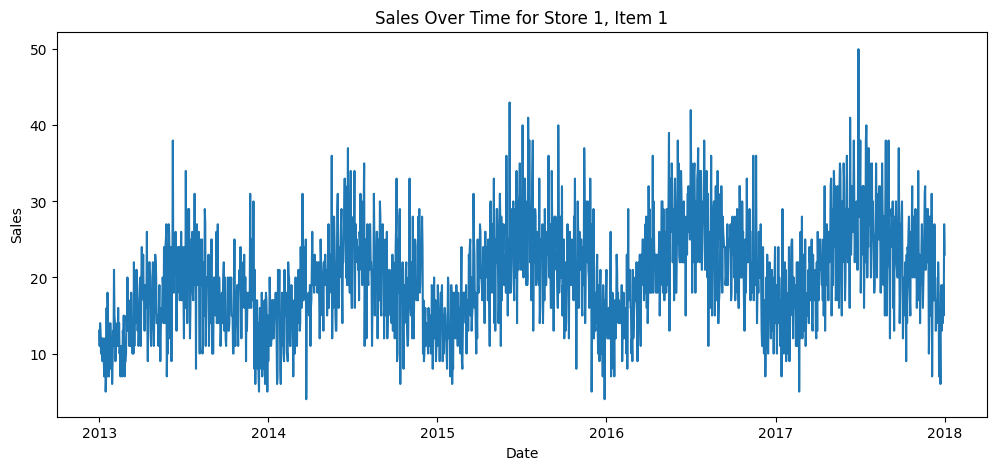

In [4]:
# Select store and item for forecasting
store_id = 1
item_id = 1

df_filtered = df[(df['store'] == store_id) & (df['item'] == item_id)].copy()
df_filtered = df_filtered.sort_values('date')
df_filtered.set_index('date', inplace=True)
display(df_filtered.head())

# Plot sales over time
plt.figure(figsize=(12, 5))
plt.plot(df_filtered['sales'])
plt.title(f'Sales Over Time for Store {store_id}, Item {item_id}')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.show()

## 4. Exploratory Data Analysis (EDA)
Visualize the sales time series, analyze trends, seasonality, and autocorrelation.

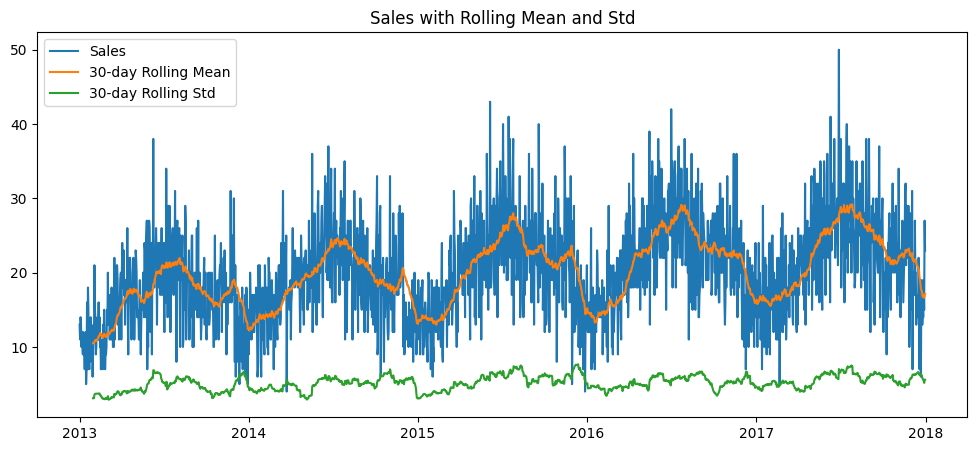

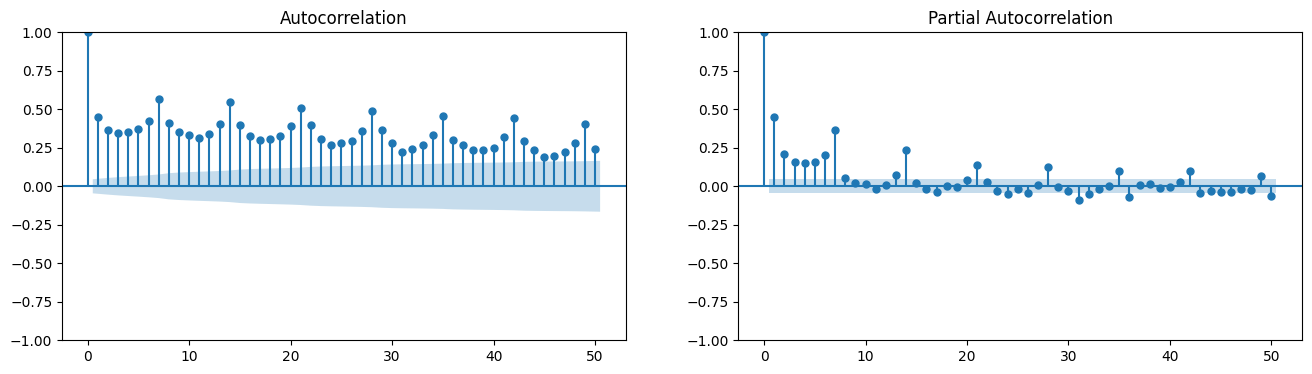

In [5]:
# Plot rolling mean and std
df_filtered['sales_rolling_mean'] = df_filtered['sales'].rolling(window=30).mean()
df_filtered['sales_rolling_std'] = df_filtered['sales'].rolling(window=30).std()

plt.figure(figsize=(12, 5))
plt.plot(df_filtered['sales'], label='Sales')
plt.plot(df_filtered['sales_rolling_mean'], label='30-day Rolling Mean')
plt.plot(df_filtered['sales_rolling_std'], label='30-day Rolling Std')
plt.legend()
plt.title('Sales with Rolling Mean and Std')
plt.show()

# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16, 4))
plot_acf(df_filtered['sales'], lags=50, ax=axes[0])
plot_pacf(df_filtered['sales'], lags=50, ax=axes[1])
plt.show()

## 5. Check for Stationarity
Perform the Augmented Dickey-Fuller (ADF) test and visualize rolling statistics to assess stationarity.

ADF Statistic: -3.157670556332791
p-value: 0.022569380626572377
Critical Value 1%: -3.4339840952648695
Critical Value 5%: -2.8631452508003057
Critical Value 10%: -2.567624583142913
Series is likely stationary.


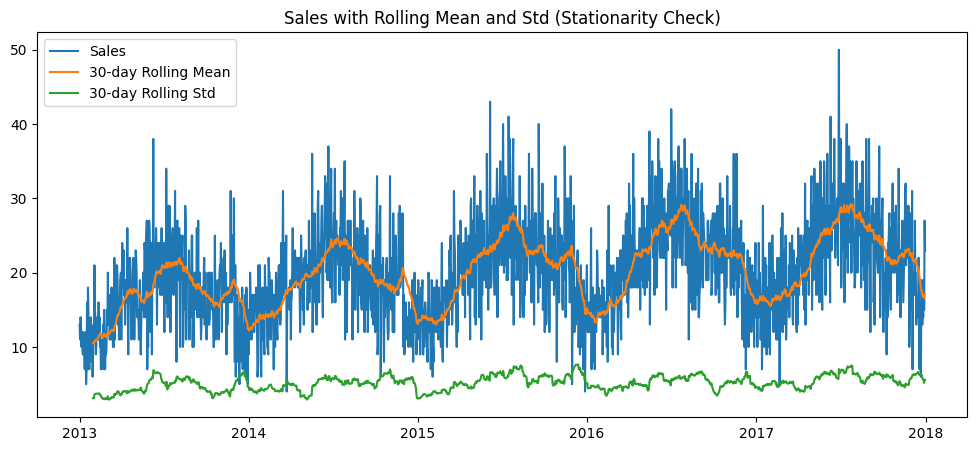

In [6]:
# Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    for key, value in result[4].items():
        print(f'Critical Value {key}: {value}')
    if result[1] < 0.05:
        print('Series is likely stationary.')
    else:
        print('Series is likely non-stationary.')

adf_test(df_filtered['sales'])

# Plot rolling mean and std again for visual check
plt.figure(figsize=(12, 5))
plt.plot(df_filtered['sales'], label='Sales')
plt.plot(df_filtered['sales_rolling_mean'], label='30-day Rolling Mean')
plt.plot(df_filtered['sales_rolling_std'], label='30-day Rolling Std')
plt.legend()
plt.title('Sales with Rolling Mean and Std (Stationarity Check)')
plt.show()

## 6. Train-Test Split
Split the time series into training and test sets for model validation.

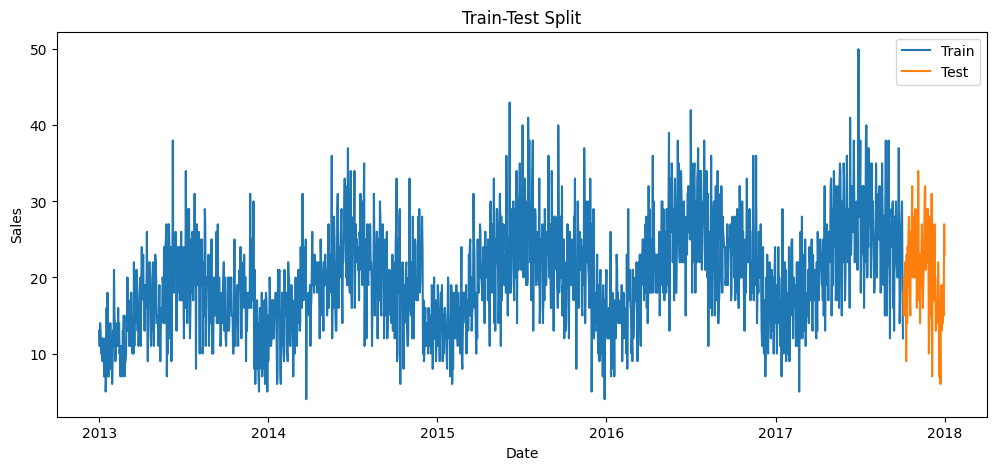

In [7]:
# Split data into train and test sets (e.g., last 3 months for testing)
test_size = 90  # days
ts = df_filtered['sales']
train, test = ts[:-test_size], ts[-test_size:]

plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.title('Train-Test Split')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

## 7. ARIMA Modeling
Fit an ARIMA model to the training data, tune parameters, and forecast sales. Plot predictions vs actuals.

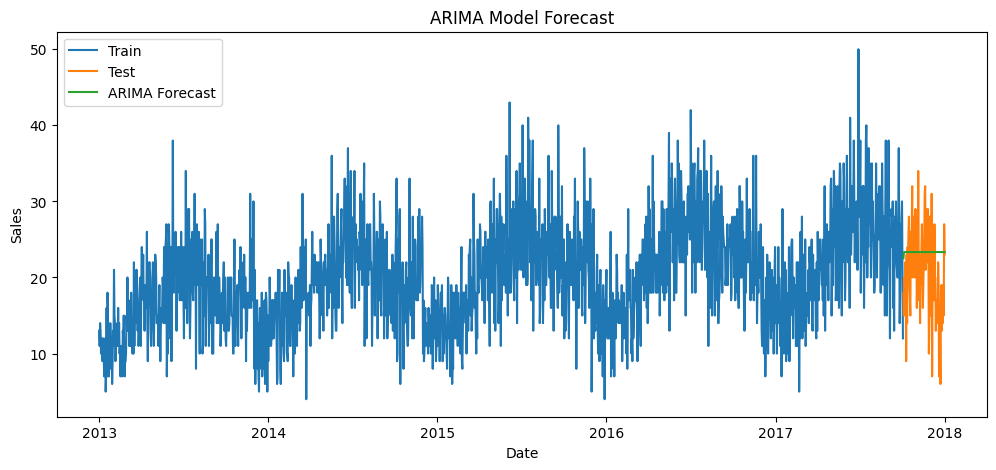

ARIMA RMSE: 6.56
ARIMA MAE: 5.30


In [8]:
# Fit ARIMA model (order can be tuned based on ACF/PACF and stationarity)
arima_order = (1,1,1)
model_arima = ARIMA(train, order=arima_order)
model_arima_fit = model_arima.fit()

# Forecast
y_pred_arima = model_arima_fit.forecast(steps=len(test))

# Plot predictions vs actuals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, y_pred_arima, label='ARIMA Forecast')
plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate metrics
arima_rmse = np.sqrt(mean_squared_error(test, y_pred_arima))
arima_mae = mean_absolute_error(test, y_pred_arima)
print(f'ARIMA RMSE: {arima_rmse:.2f}')
print(f'ARIMA MAE: {arima_mae:.2f}')

## 8. SARIMAX Modeling
Fit a SARIMAX model to the training data, tune seasonal parameters, and forecast sales. Plot predictions vs actuals.

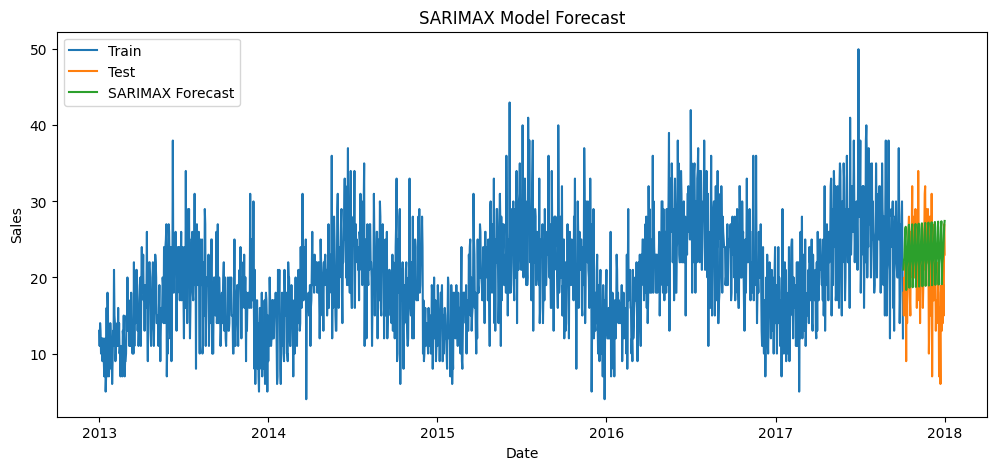

SARIMAX RMSE: 6.06
SARIMAX MAE: 4.92


In [9]:
# Fit SARIMAX model (seasonal order can be tuned based on data)
sarimax_order = (1,1,1)
seasonal_order = (1,1,1,7)  # Weekly seasonality as an example
model_sarimax = SARIMAX(train, order=sarimax_order, seasonal_order=seasonal_order)
model_sarimax_fit = model_sarimax.fit(disp=False)

# Forecast
y_pred_sarimax = model_sarimax_fit.forecast(steps=len(test))

# Plot predictions vs actuals
plt.figure(figsize=(12, 5))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, y_pred_sarimax, label='SARIMAX Forecast')
plt.title('SARIMAX Model Forecast')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

# Calculate metrics
sarimax_rmse = np.sqrt(mean_squared_error(test, y_pred_sarimax))
sarimax_mae = mean_absolute_error(test, y_pred_sarimax)
print(f'SARIMAX RMSE: {sarimax_rmse:.2f}')
print(f'SARIMAX MAE: {sarimax_mae:.2f}')

## 9. Model Evaluation and Comparison
Evaluate both models using RMSE and MAE, and compare their performance.

In [10]:
# Compare model performance
print(f'ARIMA RMSE: {arima_rmse:.2f}, MAE: {arima_mae:.2f}')
print(f'SARIMAX RMSE: {sarimax_rmse:.2f}, MAE: {sarimax_mae:.2f}')

if sarimax_rmse < arima_rmse:
    print('SARIMAX performs better for this time series.')
else:
    print('ARIMA performs better for this time series.')

ARIMA RMSE: 6.56, MAE: 5.30
SARIMAX RMSE: 6.06, MAE: 4.92
SARIMAX performs better for this time series.


## 10. Forecast Future Sales with Best Model
Use the better-performing model to forecast future sales and visualize the results.

In [11]:
# Check if required variables are defined before forecasting
required_vars = ['sarimax_rmse', 'arima_rmse', 'sarimax_order', 'seasonal_order', 'arima_order', 'ts']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    print(f"Warning: The following variables are not defined: {missing_vars}\nPlease run all previous cells in order before running the forecast.")
else:
    print("All required variables are defined. You can safely run the forecast cell.")

All required variables are defined. You can safely run the forecast cell.


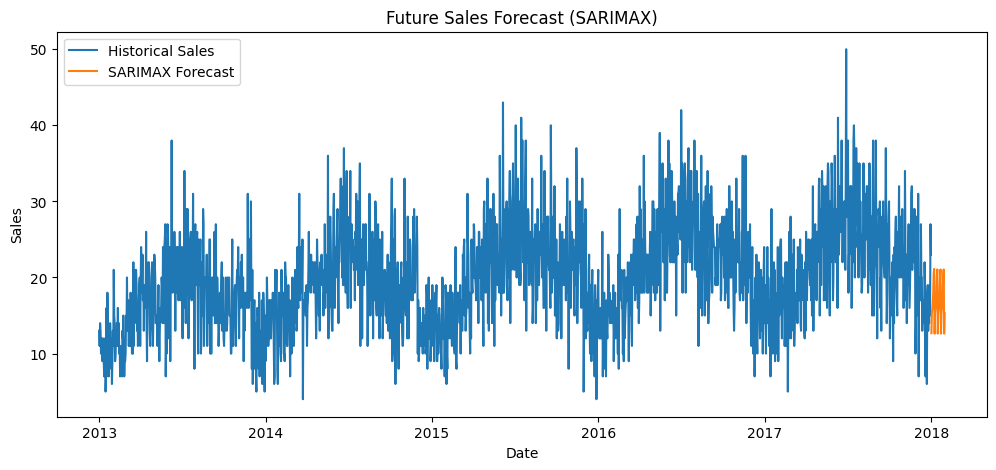

2018-01-01    12.666365
2018-01-02    15.340928
2018-01-03    15.848825
2018-01-04    16.776034
2018-01-05    18.015353
2018-01-06    20.559785
2018-01-07    21.126663
2018-01-08    12.625606
2018-01-09    15.315679
2018-01-10    15.922393
2018-01-11    16.689780
2018-01-12    18.134705
2018-01-13    20.308074
2018-01-14    21.054169
2018-01-15    12.625027
2018-01-16    15.315709
2018-01-17    15.926301
2018-01-18    16.687416
2018-01-19    18.140409
2018-01-20    20.299217
2018-01-21    21.052345
2018-01-22    12.626025
2018-01-23    15.316731
2018-01-24    15.927475
2018-01-25    16.688344
2018-01-26    18.141654
2018-01-27    20.299890
2018-01-28    21.053294
2018-01-29    12.627085
2018-01-30    15.317792
Freq: D, Name: predicted_mean, dtype: float64

In [14]:
# Forecast future sales (next 30 days) with the best model
future_steps = 30
if sarimax_rmse < arima_rmse:
    model = SARIMAX(ts, order=sarimax_order, seasonal_order=seasonal_order)
    model_fit = model.fit(disp=False)
    forecast = model_fit.forecast(steps=future_steps)
    model_name = 'SARIMAX'
else:
    model = ARIMA(ts, order=arima_order)
    model_fit = model.fit()
    forecast = model_fit.forecast(steps=future_steps)
    model_name = 'ARIMA'

# Plot the forecast
plt.figure(figsize=(12, 5))
plt.plot(ts, label='Historical Sales')
plt.plot(pd.date_range(ts.index[-1], periods=future_steps+1, freq='D')[1:], forecast, label=f'{model_name} Forecast')
plt.title(f'Future Sales Forecast ({model_name})')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

forecast